# Evaluate Rate of ML Update
Assess the performance of the machine learning models as they are updated

In [1]:
%matplotlib inline
from moldesign.score.mpnn.layers import custom_objects
from moldesign.score.mpnn import evaluate_mpnn
from matplotlib import pyplot as plt
from datetime import datetime
from functools import partial
from scipy.stats import kendalltau
import tensorflow as tf
from tqdm import tqdm
from glob import glob
import pandas as pd
import numpy as np
import json
import os
import re

RDKit WARNING: [00:17:55] Enabling RDKit 2019.09.3 jupyter extensions


Load the run information 

In [2]:
run_info = pd.read_csv('../run_data.csv')

In [3]:
run_info = run_info.sort_values('start_time', ascending=False).iloc[0].to_dict()
#run_info = run_info.query('path=="runs/10Nov20-210002-b59342"').iloc[0]  # XTB run
run_info

{'path': 'runs/16Dec20-212040-c18827',
 'param_hash': 'c18827',
 'start_time': '2020-12-16 21:20:04',
 'mpnn_config_directory': '../../ai-components/mpnn/nwchem-atomization-v0/',
 'mpnn_model_files': "['../../ai-components/mpnn/nwchem-atomization-v0/best_model.h5', '../../ai-components/mpnn/nwchem-atomization-v0/networks/b32_n512_S10/best_model.h5', '../../ai-components/mpnn/nwchem-atomization-v0/networks/b32_n512_S11/best_model.h5', '../../ai-components/mpnn/nwchem-atomization-v0/networks/b32_n512_S12/best_model.h5']",
 'initial_agent': '../../ai-components/moldqn/nwchem-atomization-v0//agent.pkl',
 'initial_search_space': '../../ai-components/moldqn/nwchem-atomization-v0//best_mols.json',
 'initial_database': '../../ai-components/mpnn/nwchem-atomization-v0//initial_database.json',
 'qc_spec': 'small_basis',
 'qc_parallelism': 4,
 'parallel_updating': 2,
 'rl_episodes': 10,
 'search_size': 1000,
 'queue_length': 1024,
 'random_frac': 0.1,
 'greedy_frac': 0.8,
 'nnodes': 128,
 'ml_node

## Load in the Trajectories
We need the records associated with QC records and model update tasks

In [4]:
result_data = pd.read_json(os.path.join('..', run_info['path'], 'simulation_records.jsonld'), lines=True).query('success')
result_data.sort_values('time_created', inplace=True)

In [5]:
update_records = pd.read_json(os.path.join('..', run_info['path'], 'update_records.jsonld'), lines=True).query('success')
print(f'Loaded {len(update_records)} update records')

Loaded 100 update records


## Evaluate Model Library Predictions after Updates
We are going to incrementally measure the predictions as model updates

In [6]:
smiles = [r['smiles'] for r in result_data['task_info']]
print(f'Found {len(smiles)} molecules to evaluate')

Found 18 molecules to evaluate


In [7]:
models = eval(run_info['mpnn_model_files'])

In [8]:
outputs = np.zeros((len(smiles), len(models), len(update_records) + 1))
print(f'Initialized a {outputs.shape} array to store predictions')

Initialized a (18, 4, 101) array to store predictions


### Load in an Initial Model
We are only going to hold one model in memory at a time

In [9]:
model = tf.keras.models.load_model(os.path.join('..', models[0]), custom_objects=custom_objects)

/lus/theta-fs0/projects/CSC249ADCD08/edw/env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/lus/theta-fs0/projects/CSC249ADCD08/edw/env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/lus/theta-fs0/projects/CSC249ADCD08/edw/env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/lus/theta-fs0/project

Create the inference function

In [10]:
with open(os.path.join('..', run_info['mpnn_config_directory'], 'atom_types.json')) as fp:
    atom_types = json.load(fp)

In [11]:
with open(os.path.join('..', run_info['mpnn_config_directory'], 'bond_types.json')) as fp:
    bond_types = json.load(fp)

In [12]:
inference_function = partial(evaluate_mpnn, atom_types=atom_types, bond_types=bond_types, batch_size=512)

### Get the Predictions of Initial Models
Get how the models perform before we start updating them

In [13]:
for i, path in tqdm(enumerate(models)):
    model.load_weights(os.path.join('..', path))
    y_pred = inference_function([model], smiles)
    outputs[:, i, :] = y_pred

4it [00:05,  1.28s/it]


### Evaluate Predictions with Updates
We are going to load in new models and re-evaluate predictions

In [14]:
updated_model_paths = glob(os.path.join('..', run_info['path'], 'models', '*.h5'))
print(f'Found {len(updated_model_paths)} model updates')

Found 100 model updates


Sort them by execution order

In [15]:
updated_models = []
for m in updated_model_paths:
    words = os.path.basename(m)[:-3].split("_")
    updated_models.append({
        'model_id': int(words[-1]),
        'index': int(words[0]),
        'path': m
    })
updated_models = pd.DataFrame(updated_models).sort_values('index')

Evaluate each new model and store how the predictions change

In [16]:
for _, r in tqdm(updated_models.iterrows(), total=len(updated_models)):
    # Update the model
    model.load_weights(r["path"])
    
    # Re-run inference
    y_pred = inference_function([model], smiles)
    
    # Store these predictions for current iteration and 
    #  all future iterations with this model. We sorted
    #  by execution order to prevent unnecessary overwriting
    outputs[:, r["model_id"], r["index"] + 1:] = y_pred

100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


## Study how Predictions they Change
See if our models improve, etc. with iteration

Make the times for each update

In [17]:
times = np.concatenate(([0], update_records['time_result_received'] - update_records['time_created'].min()))

### Models Accuracy Changes
See if the model gets better or worse with time

In [18]:
y_true = result_data['value'].values

In [19]:
maes = np.abs(outputs.mean(axis=1) - y_true[:, None]).mean(axis=0)

Text(0.5, 0, 'Walltime (s)')

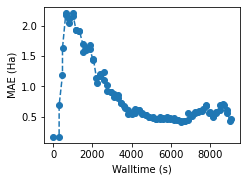

In [20]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(times, maes, '--o')

ax.set_ylabel('MAE (Ha)')
ax.set_xlabel('Walltime (s)')

## Ranking Changes
See how the predicted ranking based on the mean or standard deviation of model predictons

In [21]:
mean_order = np.argsort(outputs.mean(axis=1), axis=0)
mean_ranks = mean_order.argsort(axis=0)

In [22]:
std_order = np.argsort(outputs.std(axis=1), axis=0)
std_ranks = std_order.argsort(axis=0)

Compute how the ranking performance changes as we update the model

In [23]:
std_tau = [kendalltau(std_ranks[:, 4], s)[0] for s in std_ranks.T]

In [24]:
mean_tau = [kendalltau(mean_ranks[:, 4], s)[0] for s in mean_ranks.T]

In [25]:
mean_corr = [np.corrcoef(mean_ranks[:, 4], s)[0, 1] for s in mean_ranks.T]

In [26]:
std_corr = [np.corrcoef(std_ranks[:, 4], s)[0, 1] for s in std_ranks.T]

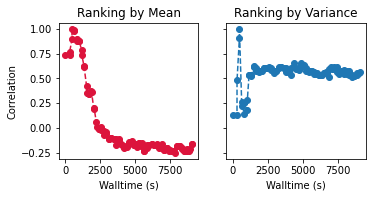

In [27]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(5.5, 2.5))

axs[0].plot(times, mean_corr, '--o', color='crimson')
axs[0].set_title('Ranking by Mean')
axs[1].plot(times, std_corr, '--o')
axs[1].set_title('Ranking by Variance')

axs[0].set_ylabel('Correlation')
for ax in axs:
    ax.set_xlabel('Walltime (s)')

*Finding*: The variance drops off slower and the correlation goes to zero.